线性网络中，因无法模拟出较为复杂的情况，故引入隐藏层（MLP）

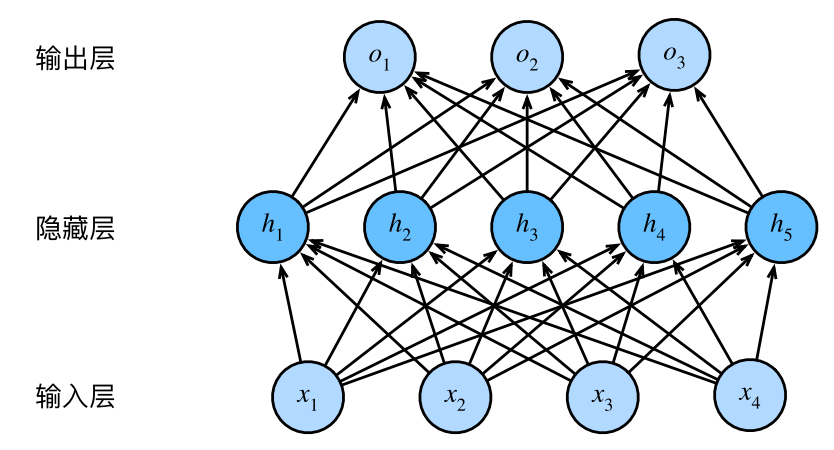

多层感知机的层数，与每层是否需要进行计算有关，上图的MLP的层数为2

MLP中加入激活函数后，即可模拟非线性函数

## 激活函数

通过计算加权和并加上偏置来确定神经元是否应该被激活，用于转化隐藏层的输出

### ReLu函数

修正线性单元（Rectified linear unit，ReLU），ReLU(x) = max(x，0)，仅保留正元素而丢弃所有负元素

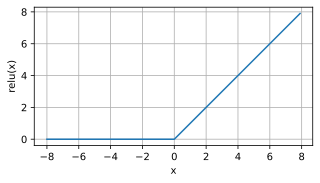

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

%matplotlib inline
import torch
from d2l import torch as d2l
# import os
# os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.relu(x)
d2l.plot(x.detach(), y.detach(), 'x', 'relu(x)', figsize=(5, 2.5))

当输入值为0时，默认该点导数为左侧导数即0，下面是ReLu函数的导数

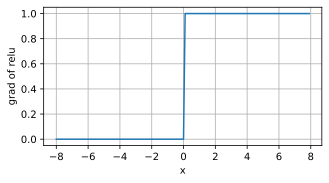

In [2]:
y.backward(torch.ones_like(x), retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of relu', figsize=(5, 2.5))

使⽤ReLU的原因是，它求导表现得特别好：要么让参数消失，要么让参数通过。这使得优化表现得更好，并且ReLU减轻了困扰以往神经⽹络的梯度消失问题

### sigmoid函数

对于⼀个定义域在R中的输⼊，sigmoid函数将输⼊变换为区间(0, 1)上的输出。因此，sigmoid通常称为挤压函数（squashing function）：它将范围（-inf, inf）中的任意输⼊压缩到区间（0, 1）中的某个值：

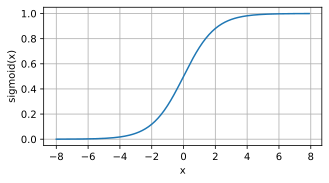

In [3]:
y = torch.sigmoid(x)
d2l.plot(x.detach(), y.detach(), 'x', 'sigmoid(x)', figsize=(5, 2.5))

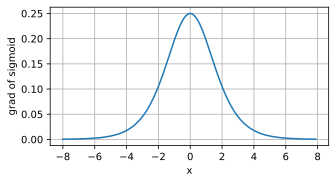

In [4]:
# 清除以前的梯度
x.grad.data.zero_()
y.backward(torch.ones_like(x),retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of sigmoid', figsize=(5, 2.5))


### tanh函数


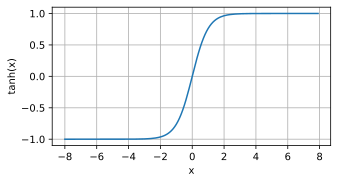

In [5]:
y = torch.tanh(x)
d2l.plot(x.detach(), y.detach(), 'x', 'tanh(x)', figsize=(5, 2.5))

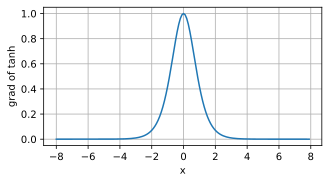

In [6]:
# 清除以前的梯度
x.grad.data.zero_()
y.backward(torch.ones_like(x),retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of tanh', figsize=(5, 2.5))

## 多层感知机简洁实现

In [7]:
import torch
from torch import nn
from d2l import torch as d2l

### 模型

Fashion-MNIST中的每个图像由 28 * 28 = 784个灰度像素值组成。所有图像共分为10个类别。忽略像素之间的空间结构，我们可以将每个图像视为具有784个输⼊特征和10个类的简单分类数据集。⾸先，我们将实现⼀个具有单隐藏层的多层感知机，它包含256个隐藏单元。注意，我们可以将这两个变量都视为超参数。通常，我们选择**2的若⼲次幂**作为层的宽度。因为内存在硬件中的分配和寻址⽅式，这么做往往可以在计算上更⾼效。

In [8]:
net = nn.Sequential(nn.Flatten(),               #   将连续的维度范围展平成为张量，默认从第1个到最后一个（0为开始维度）
                    nn.Linear(784, 256),
                    nn.ReLU(),
                    nn.Linear(256, 10))
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);        #   递归地将函数应用到net的子模块中

In [9]:
batch_size, lr, num_epochs = 256, 0.1, 10
loss = nn.CrossEntropyLoss(reduction='none')        #   交叉熵损失函数
trainer = torch.optim.SGD(net.parameters(), lr=lr)  #   优化函数

RuntimeError: grad can be implicitly created only for scalar outputs

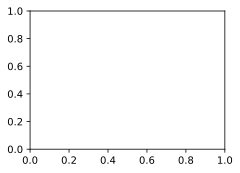

In [10]:
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

将模型在训练数据上拟合的⽐在潜在分布中更接近的现象称为过拟合（overfitting），⽤于对抗过拟合的技术称为正则化（regularization）。

**欠拟合**：训练误差与验证误差很小，模型不能降低训练误差，说明模型过于简单不能学习到模式

**过拟合**：训练误差明显低于验证误差

## 权重衰减

用于控制神经网络模型复杂度和减少过拟合的技术。在训练神经网络时，权重衰减通过在损失函数中引入权重的平方和来惩罚较大的权重值。

**目的**：防止模型过度依赖某些特征或权重，从而提高模型的泛化能力。  
**实现方式**：通过将一个正则化项加到损失函数中来实现，通过对较大的权重进行惩罚，权重衰减鼓励模型选择较小的权重值，使得模型对输入数据的微小变化更加敏感，减少过拟合的风险。
权重衰减功能在深度学习框架的优化器中提供。

## dropout(暂退法)

**平滑性**：函数不应该对其输⼊的微⼩变化敏感。  
在训练过程中，他们建议在计算后续层之前向⽹络的每⼀层注⼊噪声。因为当训练⼀个有多层的深层⽹络时，注⼊噪声只会在输⼊-输出映射上增强平滑性。这个想法被称为暂退法（dropout）

In [12]:
net = nn.Sequential(nn.Flatten(),
            nn.Linear(784, 256),
            nn.ReLU(),
            # 在第⼀个全连接层之后添加⼀个dropout层
            nn.Dropout(0.2),
            nn.Linear(256, 256),
            nn.ReLU(),
            # 在第⼆个全连接层之后添加⼀个dropout层
            nn.Dropout(0.5),
            nn.Linear(256, 10))
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)
        
net.apply(init_weights);

RuntimeError: grad can be implicitly created only for scalar outputs

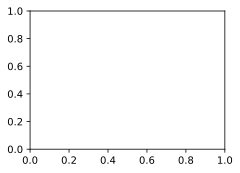

In [13]:
trainer = torch.optim.SGD(net.parameters(), lr=lr)
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

## 前向传播、反向传播、计算图

### 前向传播
按顺序（从输⼊层到输出层）计算和存储神经⽹络中每层的结果。
### 反向传播
该⽅法根据微积分中的链式规则，按相反的顺序从输出层到输⼊层遍历⽹络

**梯度消失**：在反向传播过程中，随着梯度从输出层向输入层传播，梯度逐渐变小并趋近于零。当梯度消失时，模型的参数更新变得非常小，导致网络无法有效地学习和调整参数。梯度消失通常发生在深度神经网络中，特别是在使用激活函数为Sigmoid或Tanh的网络中，这些激活函数的导数在某些区域接近于零，从而导致梯度逐渐缩小。  
**梯度爆炸**：梯度在反向传播过程中变得非常大，迅速增长。当梯度爆炸时，参数的更新幅度会变得非常大，导致模型不稳定甚至无法收敛。梯度爆炸通常发生在网络层数较多、参数初始化不当或学习率过高的情况下。